## Cloud Detection in Landsat 8 Images
Author: Taimoor Akhtar

Date: December 22, 2021

### Problem Statement
Using the **[SPARC Dataset](https://www.usgs.gov/landsat-missions/spatial-procedures-automated-removal-cloud-and-shadow-sparcs-validation-data)**

In [4]:
import numpy as np
from data_preparation import *
from matplotlib import pyplot as pyplot
%matplotlib inline

### 1. Data Preparation

#### 1.1. Divide data into Train, Validation and Test Sets
We first divide the SPARC Dataset into three sets of training, validation and test sets. The basic strategy of division is to split the 80 Landsat images of SPARC into a subset of 50 training images, 15 validation images and 15 test images. Moreover, we attempt to ensure that proportion of cloud pixels in all datasets are similar.


In [5]:
scene_ids = get_scene_ids() # First get image ids of all 80 images
_, _, cloud_ratios = create_label_data(scene_ids) # Traverse the data labels of images to compute cloud proportions
train_ids, val_ids, test_ids = create_train_validation_test_sets(scene_ids, cloud_ratios)

In [6]:
# Check if proportions of cloud & shadow pixels in all datasets are comparable
print('Proportion of cloud & shadow pixels in all data: {0:0.4f}'. format(np.asarray(list(cloud_ratios.values())).mean()))
train_ratios = {k:v for k, v in cloud_ratios.items() if k in train_ids}
print('Proportion of cloud & shadow pixels in training data: {0:0.4f}'. format(np.asarray(list(train_ratios.values())).mean()))
val_ratios = {k:v for k, v in cloud_ratios.items() if k in val_ids}
print('Proportion of cloud & shadow pixels in validation data: {0:0.4f}'. format(np.asarray(list(val_ratios.values())).mean()))
test_ratios = {k:v for k, v in cloud_ratios.items() if k in test_ids}
print('Proportion of cloud & shadow pixels in test data: {0:0.4f}'. format(np.asarray(list(test_ratios.values())).mean()))

Proportion of cloud & shadow pixels in all data: 0.2675
Proportion of cloud & shadow pixels in training data: 0.2722
Proportion of cloud & shadow pixels in validation data: 0.2748
Proportion of cloud & shadow pixels in test data: 0.2444


We see that our strategy of maintaining cloud & shadow pixel ratio of around 25% when splitting data into training, validation and test sets has worked well. We can store the image ids for the different sets for future purposes. 

In [19]:
import pickle
pickle.dump(train_ids, open('training_set_ids.pkl', 'wb'))
pickle.dump(val_ids, open('validation_set_ids.pkl', 'wb'))
pickle.dump(test_ids, open('test_set_ids.pkl', 'wb'))

#### 1.2. Prepare Input Features and Labels
Now that the Landsat images are divided into training, validation and test sets, we now prepare input features and labels for the three sets. Initiat analysis of the Landsat band tif files revealed 10 bands for each input pixel. While it is possible to create new input features by combining different bands (via feature engineering), in this modeling exercise we will use the raw values of the 10 bands as input features only.   

In [7]:
# A - Prepare training dataset
df_train = None
for scene_id in train_ids:
    if df_train is None:
        df_train = create_dataset_from_scene(scene_id)
    else:
        df = create_dataset_from_scene(scene_id)
        df_train = df_train.append(df, ignore_index=True)

In [8]:
# B - Prepare validation dataset
df_val = None
for scene_id in val_ids:
    if df_val is None:
        df_val = create_dataset_from_scene(scene_id)
    else:
        df = create_dataset_from_scene(scene_id)
        df_val = df_val.append(df, ignore_index=True)

In [9]:
# C - Prepare test dataset
df_test = None
for scene_id in test_ids:
    if df_test is None:
        df_test = create_dataset_from_scene(scene_id)
    else:
        df = create_dataset_from_scene(scene_id)
        df_test = df_test.append(df, ignore_index=True)

## 2. Model Development
### 2.1. Train Initial Model
We will now train an initial Machine Learning model using training data. Given its speed of training and prediction, we choose **LightGBM** as the ML algorithm for cloud detection.

C:\Users\TPPA\Miniconda3\envs\ml-cd\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	Training's binary_logloss: 0.318219	Validation's binary_logloss: 0.380472
[20]	Training's binary_logloss: 0.248299	Validation's binary_logloss: 0.336764
[30]	Training's binary_logloss: 0.221503	Validation's binary_logloss: 0.323036
[40]	Training's binary_logloss: 0.207743	Validation's binary_logloss: 0.316318
[50]	Training's binary_logloss: 0.198835	Validation's binary_logloss: 0.31719
[60]	Training's binary_logloss: 0.192462	Validation's binary_logloss: 0.315468
[70]	Training's binary_logloss: 0.187349	Validation's binary_logloss: 0.317942
[80]	Training's binary_logloss: 0.183455	Validation's binary_logloss: 0.319798
[90]	Training's binary_logloss: 0.179874	Validation's binary_logloss: 0.320328
[100]	Training's binary_logloss: 0.176471	Validation's binary_logloss: 0.322623


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

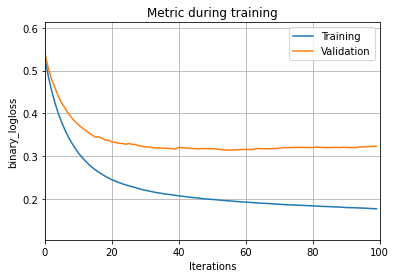

In [10]:
import lightgbm as lgb

# Create Input feature and output training and validation arrays
X_train = df_train.drop(['label', 'bin_label'], axis=1)
y_train = df_train['bin_label'].to_numpy() 
X_val = df_val.drop(['label', 'bin_label'], axis=1)
y_val = df_val['bin_label'].to_numpy()

# Fit LightGBM Classifier on
model = lgb.LGBMClassifier()
model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], eval_names=['Validation', 'Training'], verbose=10)
lgb.plot_metric(model)

We will also test performance of the trained model on the validation dataset in order to assess if model performance is adequate with default **hyperparameters**.

In [11]:
from sklearn.metrics import accuracy_score
# Training set score
y_pred_train = model.predict(X_train)
print('LightGBM Model training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
# Validation set score
y_pred_val = model.predict(X_val)
accuracy=accuracy_score(y_pred_val, y_val)
print('LightGBM Model validation-set accuracy score: {0:0.4f}'.format(accuracy_score(y_val, y_pred_val)))

LightGBM Model training-set accuracy score: 0.9310
LightGBM Model validation-set accuracy score: 0.8413


### 2.2. Hyperparameter Tuning
In section 2.1, we trained a LightGBM model to detect clouds and cloud shadows using **default** model hyperparameters. Using **accuracy** (i.e., fraction of predictions that model got right) as the  **evaluation metric** we quickly assessed the default model's accuracy on both training and validation datasets. The 93% accuracy in training and 86% accuracy in validation is good but there may be an opportunity to tune some hyperparameters to slightly improve upon this and to also guard against overfitting. Hence, we attempt to manually specify some hyperparameters based on recommendations provided in [this medium article](https://medium.com/sentinel-hub/improving-cloud-detection-with-machine-learning-c09dc5d7cf13). Moreover, `n_estimators` is reduced to 50 as we see that validation accuracy tends to become worse after 50 iterations. 

C:\Users\TPPA\Miniconda3\envs\ml-cd\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[10]	Training's binary_logloss: 0.318219	Validation's binary_logloss: 0.380472
[20]	Training's binary_logloss: 0.248299	Validation's binary_logloss: 0.336764
[30]	Training's binary_logloss: 0.221503	Validation's binary_logloss: 0.323036
[40]	Training's binary_logloss: 0.207743	Validation's binary_logloss: 0.316318
[50]	Training's binary_logloss: 0.199539	Validation's binary_logloss: 0.310315


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

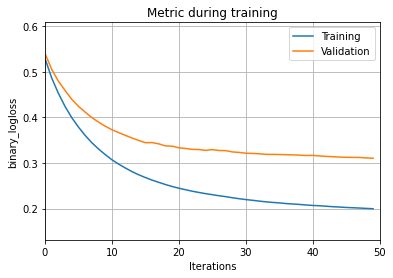

In [12]:
params = {
    "min_data_in_leaf": 1500,
    "n_estimators": 50
}
tuned_model = lgb.LGBMClassifier(**params)
tuned_model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], eval_names=['Validation', 'Training'], verbose=10)
lgb.plot_metric(tuned_model)

We can now validate if model performance is satisfactory with modified **hyperparameters**.

In [13]:
# Training set score
y_pred_train = tuned_model.predict(X_train)
print('LightGBM Model training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
# Validation set score
y_pred_val = tuned_model.predict(X_val)
accuracy=accuracy_score(y_pred_val, y_val)
print('LightGBM Model validation-set accuracy score: {0:0.4f}'.format(accuracy_score(y_val, y_pred_val)))

LightGBM Model training-set accuracy score: 0.9234
LightGBM Model validation-set accuracy score: 0.8496


The difference between training and validation accuracy scores has slightly reduced, implying a possible improvement in model robustness. We will not attempt further hyperparameter tuning. However, it is possible to automate the hyperparameter tuning process in future, to further improve model performance, by setting up grid search, random search or bayesian optimization for hyperparameter optimization. 

### 2.3. Feature Importance
Lets also take a quick looks at feature importance, to see if some input bands can be dropped as model input features. 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

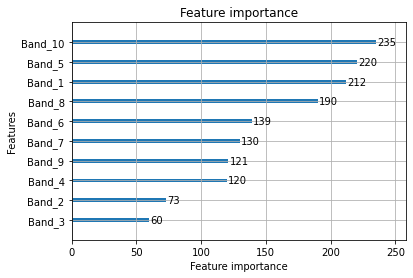

In [14]:
lgb.plot_importance(tuned_model)

It is very evident that all Landsat image bands are importance input features for cloud detection.

## 3. Model Evaluation
We will now evaluate our trained LightGBM model on the independent test set. Moreover, we will save the final model to a file, so that it can be retrieved and used generically for cloud detection.

### 3.1 Save Model
We will first save the tuned model, so that it can be reloaded for cloud detection in future. 

In [15]:
import pickle
pickle.dump(tuned_model, open('cloud_detection_model.pkl', 'wb'))

### 3.2. Metric-based Model Testing
We will now test the trained model on test set. One appropriate evaluation criteria could be the **confusion matrix**.

C:\Users\TPPA\Miniconda3\envs\ml-cd\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


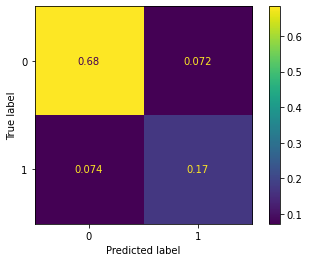

In [16]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tuned_model, df_test.drop(['label', 'bin_label'], axis=1), df_test['bin_label'].to_numpy(), normalize='all')

The confusion matrix tends to indicate that we are working on a problem that is **imbalanced**, i.e., around 24% (0.074 + 0.17) of pixels in the test set are actually cloud & shadows. Hence, it is important to look at recall and precision in addition to accuracy, to ascertain model performance.

In [17]:
from sklearn.metrics import classification_report
X_test = df_test.drop(['label', 'bin_label'], axis=1)
y_test = df_test['bin_label'].to_numpy()
y_pred_test = model.predict(X_test)

print('LightGBM Model test-set accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))
print(classification_report(y_test, y_pred_test, target_names=['Not Cloud', 'Cloud']))

LightGBM Model test-set accuracy score: 0.8511
              precision    recall  f1-score   support

   Not Cloud       0.90      0.90      0.90  11334254
       Cloud       0.69      0.70      0.70   3665746

    accuracy                           0.85  15000000
   macro avg       0.80      0.80      0.80  15000000
weighted avg       0.85      0.85      0.85  15000000



### 3.3. Model Performance Verdict and Future Improvements
Looking closely at **precision** and **recall** scores (both at around 70%) gives a better picture of model performance. The model can definitely be improved by exploring other ML algorithms and also via a more robust hyperparameter tuning. Furthermore, it may be better to classify clouds & shadows separately. In the current model, we combined clouds and shadows into a single group to convert our problem into a binary classification problem for cloud detection.

### 3.3. Prediction Generalization
We have created a generic function that can use the saved ML model to detect clouds for any image that is provided as input. It is assumed here that 10 Landsat bands are available as input features (with the same order) for making the prediction and that file format of the input tif / raster is the same as in the SPARC dataset. The generic function is called `detect_clouds`. We test the function below on one of the images from the test set.

In [22]:
from cloud_detection import detect_clouds
scene_id = "LC80150242014146LGN00_23" #image id from test set

cloud_mask = detect_clouds(scene_id) # the cloud mask is returned as numpy array and also stored as png

The generated cloud mask png is stored in this repository for review. We can see that our algorithm has done a decent job of detecting clouds and cloud shadows. However, in this figure the algorithm is falsely tagging some pixels just outside the clouds and shadows as clouds & shadows. Maybe the classification **threshold** could be reduced in future to improve prediction. 